# Latent Dirichlet allocation (LDA)

In [1]:
import numpy as np
import pandas as pd
import gensim
import re
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

In [3]:
#import data
comments = pd.read_csv('data/comments.csv')[['comments']].dropna().drop_duplicates()
len(comments['comments'])

4236

In [4]:
#Preprocessing

STOP_WORDS = STOP_WORDS.union({'ll', 've', 'pron',
                               'good','great', 'nice',
                               'ride','route','road','rt','roads'
                              })

## Text Processing

In [5]:
ngram_range = (2, 3)

vectorizer = CountVectorizer(ngram_range=ngram_range,
                             stop_words=STOP_WORDS,
                            )
analyzer = vectorizer.build_analyzer()

texts = comments.comments.values.tolist()
processed_text = [analyzer(text) for text in texts]

In [6]:
dictionary = gensim.corpora.Dictionary(processed_text)
print('Number of unique tokens: {}'.format(len(dictionary)))

Number of unique tokens: 312243


In [7]:
corpus = [dictionary.doc2bow(t) for t in processed_text]

## Initial LDA Model

In [18]:
#LDA model parameters
num_topics = 4
num_words = 10

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                            id2word=dictionary,
                                            num_topics=num_topics, 
                                            random_state=17, update_every=1,
                                            chunksize=1500, 
                                            passes=5, iterations=10,
                                            alpha='asymmetric', eta=1/100,
                                            per_word_topics=True)

pprint(lda_model.print_topics(num_words=num_words))

[(0,
  '0.006*"beautiful scenery" + 0.004*"little traffic" + 0.004*"speed limit" + '
  '0.003*"elevation changes" + 0.003*"places stop" + 0.003*"twists turns" + '
  '0.003*"highly recommend" + 0.003*"ridden times" + 0.002*"sure stop" + '
  '0.002*"lots curves"'),
 (1,
  '0.002*"tail dragon" + 0.002*"lot fun" + 0.002*"blue ridge" + 0.002*"https '
  'www" + 0.001*"beautiful scenery" + 0.001*"lake superior" + 0.001*"best '
  'rides" + 0.001*"memorial day" + 0.001*"crotch rocket" + 0.001*"north end"'),
 (2,
  '0.002*"tail dragon" + 0.002*"million dollar" + 0.002*"rock state park" + '
  '0.002*"rock state" + 0.002*"cross village" + 0.002*"state park" + '
  '0.002*"lake michigan" + 0.001*"trip times" + 0.001*"poudre canyon" + '
  '0.001*"speed limit"'),
 (3,
  '0.002*"turn left" + 0.001*"patches gravel" + 0.001*"turn right" + '
  '0.001*"weekend traffic" + 0.001*"red bluff" + 0.001*"plan accordingly" + '
  '0.001*"140 miles" + 0.001*"blind corners" + 0.001*"rd turn" + 0.001*"left '
  'hwy"')

In [19]:
# get_document_topics method shows the topics found 
# in each corpus doc
# i = 0
# print(comments.iloc[i], processed_text[i], lda_model.get_document_topics(corpus[i]))

In [20]:
# extracts dominant topic (and percentage) for each comment

def get_main_topic_df(model, bow, texts):
    topic_list = []
    percent_list = []
    keyword_list = []
    
    for wc in bow:
        topic, percent = sorted(model.get_document_topics(wc), key=lambda x: x[1], reverse=True)[0]
        topic_list.append(topic)
        percent_list.append(round(percent, 3))
        keyword_list.append(' '.join(sorted([x[0] for x in model.show_topic(topic)])))

    result_df = pd.concat([pd.Series(topic_list, name='Dominant_topic'), 
                           pd.Series(percent_list, name='Percent'), 
                           pd.Series(texts, name='Processed_text'), 
                           pd.Series(keyword_list, name='Keywords')], axis=1)

    return result_df

In [21]:
main_topic_df = get_main_topic_df(lda_model, corpus, processed_text)

In [22]:
# len(main_topic_df)

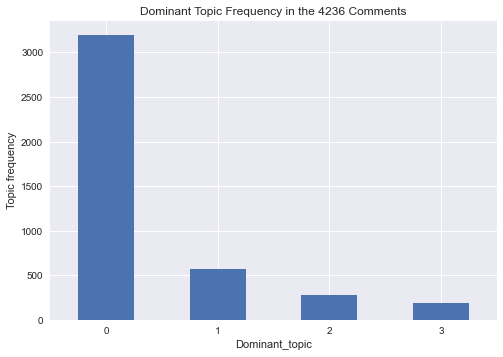

In [23]:
plt.style.use('seaborn')

grouped_topics = main_topic_df.groupby('Dominant_topic')
grouped_topics.count()['Processed_text'].\
    plot.bar(rot=0).\
    set(title=f'Dominant Topic Frequency in the {len(comments)} Comments',
        ylabel='Topic frequency');


## Representative data

What's the "most representative" comment we have in the data for each topic?  

In [24]:
representatives = pd.DataFrame()

for k in grouped_topics.groups.keys():
    representatives = pd.concat([ representatives, 
                                 grouped_topics.get_group(k).sort_values(['Percent'], ascending=False).head(3)])
# representatives
for i in range(len(representatives)):
    print(f'''
        Document: {representatives.index[i]}  
        Dominant topic: {representatives.loc[representatives.index[i]]['Dominant_topic']}\n 
    ''')
    print(texts[representatives.index[i]] + '\n ------- \n')


        Document: 236  
        Dominant topic: 0
 
    
I was the rider who nominated the route for publishing.,As of 9/26/2020, there are two articles related to Caesar's Head.  One takes you from Brevard ("Caesar's Ascent") and the other from Hwy 11 ("Caesar's Head").  Going to attempt a cross post in both. 

Rode Hwy 276 on 9/19/20 from Cherokee Foothills Scenic Hwy 11 to Brevard, NC.  Video is not excellent, but will give you some ideas of the road quality as of 2020.   https://youtu.be/Pe-zINWqMz4

Picking up from Hwy 11, it's a spirited ride.  The road condition has deteriorated with some spots where the road has been undermined and some signs of pavement sloughing.  (Rated 4 for the excellent curves, but only "fair" road condition)

Automobile traffic is courteous.  Plenty of pullouts allow slower traffic to let others pass.  The park at Caesar's Head was closed when i passed.  It was a Saturday and they had reached capacity.  Watch for people parking on the roadside on days l

## Length of documents in each topic

In [25]:
def word_count_by_topic(topic=0):
    d_lens = [len(d) for d in grouped_topics.get_group(topic)['Processed_text']]
    plt.hist(d_lens, bins=50)
    large = plt.gca().get_ylim()[1]
    d_mean = round(np.mean(d_lens), 1)
    d_median = np.median(d_lens)
    plt.plot([d_mean, d_mean], [0,large], label='Mean = {}'.format(d_mean))
    plt.plot([d_median, d_median], [0,large], label='Median = {}'.format(d_median))
    plt.legend()
    plt.gca().set(xlabel='Document word count', ylabel='Number of documents', xlim=(0, 450), 
            title='Distribution of Comment Lengths for {} Comments in Topic {}'.format(len(d_lens), topic));

In [26]:
slider = IntSlider(min=0, max=num_topics-1, step=1, value=0, description='Topic')
interact(word_count_by_topic, topic=slider);

interactive(children=(IntSlider(value=0, description='Topic', max=3), Output()), _dom_classes=('widget-interac…

## Top word distribution per topic

list

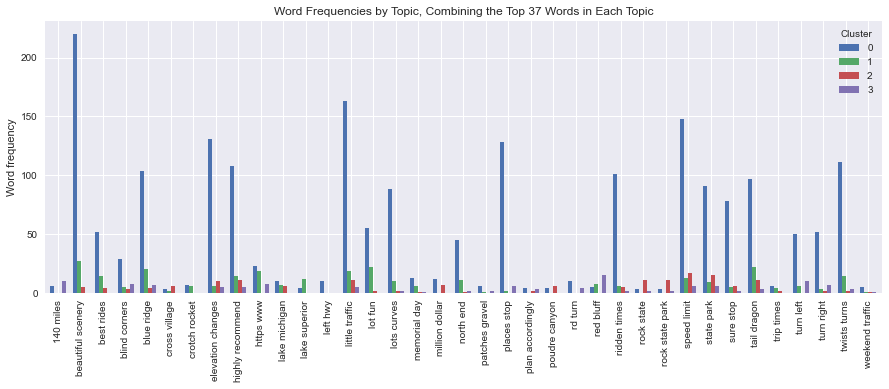

In [29]:
lda_top_words_index = set()
for i in range(lda_model.num_topics):
    lda_top_words_index = lda_top_words_index.union([k for (k,v) in lda_model.get_topic_terms(i)])

#print('Indices of top words: \n{}\n'.format(lda_top_words_index))
words_we_care_about = [{dictionary[tup[0]]: tup[1] for tup in lst if tup[0] in lda_top_words_index} 
                       for lst in corpus]
lda_top_words_df = pd.DataFrame(words_we_care_about).fillna(0).astype(int).sort_index(axis=1)
lda_top_words_df['Cluster'] = main_topic_df['Dominant_topic']
plot = (
    lda_top_words_df
    .groupby('Cluster').sum().transpose()
    .plot.bar(figsize=(15, 5), width=0.7)
    .set(ylabel='Word frequency', 
         title=f'Word Frequencies by Topic, Combining the Top {len(lda_top_words_index)} Words in Each Topic')
)
type(plot)

## Coherence scores based on number of topics

In [ ]:
# coherence_scores = []

# for n in range(1, 5):
#     mod = gensim.models.ldamodel.LdaModel(corpus=corpus, 
#                                           id2word=dictionary,
#                                           num_topics=n, 
#                                           random_state=117, update_every=1,
#                                           chunksize=1500, 
#                                           passes=5, iterations=10,
#                                           alpha='asymmetric', eta=1/100,
#                                           per_word_topics=True)
#     cmodel = gensim.models.coherencemodel.CoherenceModel(model=mod,
#                                                  texts=processed_text,
#                                                  dictionary=dictionary)
#     coherence_scores.append((n, cmodel.get_coherence()))

# topic_range = [coherence_scores[i][0] for i in range(len(coherence_scores))]
# cscore = [coherence_scores[i][1] for i in range(len(coherence_scores))]

In [ ]:
# print(f'Coherence scores for the ngram range: {ngram_range} \n {coherence_scores}')
# plt.plot(topic_range,cscore)

# Conclusions

- There seem to be 3-4 groups of users making comments on this website.
- IF 3:
    0. The 'core' group of users make most of the comments.
    1. The second group are those who are not as frequent commenters, but when they do post, they usually share videos/links to other sites.
    2. The last group do not frequently comment or share videos/links.
- IF 4:
    0. The 'core' group of users make most of the comments.
    1. Post like core group, but less overall. Maybe newer members/budding 'core' group?
    2. People riding the tail of the dragon.
    3. Other infrequent posters.